<a href="https://colab.research.google.com/github/JaiminPatel23/DL/blob/main/LAB/J035_DL_LAB11_30_03_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building image pairs for Siamese Networks with Python

Siamese networks are incredibly powerful networks, responsible for significant increases in face recognition, signature verification, and prescription pill identification applications (just to name a few).

We use siamese networks when performing verification, identification, or recognition tasks, the most popular examples being face recognition and signature verification.

For example, let’s suppose we are tasked with detecting signature forgeries. Instead of training a classification model to correctly classify signatures for each unique individual in our dataset (which would require significant training data), what if we instead took two images from our training set and asked the neural network if the signatures were from the same person or not?

If the two signatures are the same, then siamese network reports “Yes”. Otherwise, if the two signatures are not the same, thereby implying a potential forgery, the siamese network reports “No”.

This is an example of a verification task (versus classification, regression, etc.), and while it may sound like a harder problem, it actually becomes far easier in practice — we need significantly less training data, and our accuracy actually improves by using siamese networks rather than classification networks.

Another added benefit is that we no longer need a “catch-all” class for when our classification model needs to select “none of the above” when making a classification (which in practice is quite error prone). Instead, our siamese network handles this problem gracefully by reporting that the two signatures are not the same.

Keep in mind that the siamese network architecture doesn’t have to concern itself with classification in the traditional sense of having to select 1 of N possible classes. Rather, the siamese network just needs to be able to report “same” (belongs to the same class) or “different” (belongs to different classes).

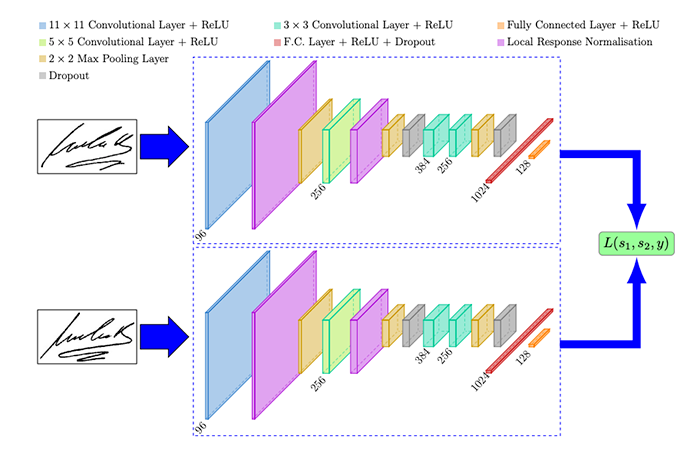

##The concept of “Image Pairs” in Siamese Networks

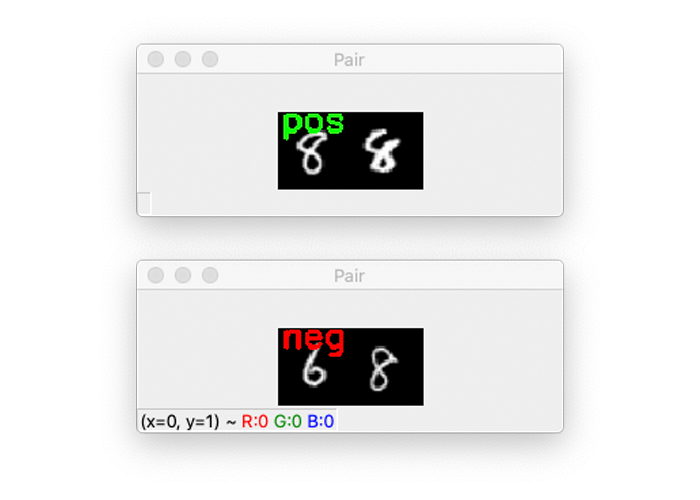

After reviewing the previous section, you should understand that a siamese network consists of two subnetworks that mirror each other (i.e., when the weights update in one network, the same weights are updated in the other network).

Since there are two subnetworks, we must have two inputs to the siamese model (as you saw in Figure 2 at the top of the previous section).

When training siamese networks we need to have positive pairs and negative pairs:

1. Positive pairs: Two images that belong to the same class (ex., two images of the same person, two examples of the same signature, etc.)
2. Negative pairs: Two images that belong to different classes (ex., two images of different people, two examples of different signatures, etc.)

When training our siamese network, we randomly sample examples of positive and negative pairs. These pairs serve as our training data such that the siamese network can learn similarity.

In [ ]:
import os
from imutils import build_montages
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Conv2D, Dropout, GlobalAveragePooling2D, MaxPooling2D
import tensorflow.keras.backend as K


##Making the Data

Making Image Pairs

In [ ]:
def make_pairs(images, labels):
	pairImages = []
	pairLabels = []
  
  # Seeing the number of unique labels in the dataset
	numClasses = len(np.unique(labels))
 
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]

  # Going through all the images
	for idxA in range(len(images)):
		# Getting one image
		currentImage = images[idxA]
		label = labels[idxA]
		
    # Another random image of same class
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]

		# Making a positive pair, and saving label, i.e. same image & label = 0
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])
  	
    # Random image of another class
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]
		
    # Making a negative pair and saving the label, i.e., different image & label = 1
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])
	
	return (np.array(pairImages), np.array(pairLabels))

Performing on MNIST

In [ ]:
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX/255.0
testX = testX/255.0

# Build the positive and negative image pairs
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

images = []
print(pairTrain.shape)

11493376/11490434 [==============================] - 0s 0us/step
(120000, 2, 28, 28)


Checking one of the pairs

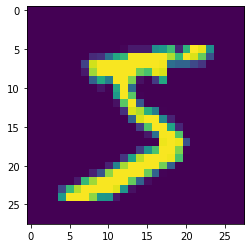

In [ ]:
plt.imshow(pairTrain[0, 0])

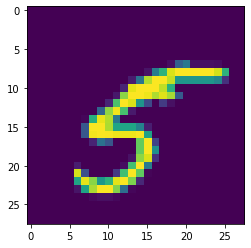

In [ ]:
plt.imshow(pairTrain[0, 1])


For ease of Visualizations

In [ ]:
for i in np.random.choice(np.arange(0, len(pairTrain)), size=(49,)):
	imageA = pairTrain[i][0]
	imageB = pairTrain[i][1]
	label = labelTrain[i]
	
	output = np.zeros((36, 60), dtype="uint8")
	pair = np.hstack([imageA, imageB])
	output[4:32, 0:56] = pair
	
	text = "neg" if label[0] == 0 else "pos"
	color = (0, 0, 255) if label[0] == 0 else (0, 255, 0)
	
	vis = cv2.merge([output] * 3)
	vis = cv2.resize(vis, (96, 51), interpolation=cv2.INTER_LINEAR)
	cv2.putText(vis, text, (2, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)

	images.append(vis)


Display +ve & -ve pairs

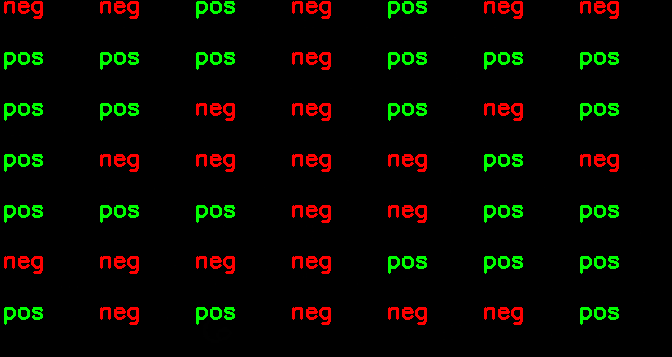

-1

In [ ]:
montage = build_montages(images, (96, 51), (7, 7))[0]

cv2_imshow(montage)
cv2.waitKey(0)

##Model Building

Specifying Important Model Parameters

In [ ]:
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 64
EPOCHS = 100
BASE_OUTPUT = "output"

# Path to model
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])

# Path to model plot
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

##Build the Siamese Model

In [ ]:
def build_siamese_model(inputShape, embeddingDim = 48):
	inputs = Input(inputShape)
	
  # First Layer
	x = Conv2D(64, (2, 2), padding = "same", activation = "relu")(inputs)
	x = MaxPooling2D(pool_size = (2, 2))(x)
	x = Dropout(0.3)(x)
 
	# Second Layer
	x = Conv2D(64, (2, 2), padding = "same", activation = "relu")(x)
	x = MaxPooling2D(pool_size = 2)(x)
	x = Dropout(0.3)(x)
 
 	# Making the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)
	
  # Making the model
	model = Model(inputs, outputs)

	return model

Finding Euclidean Distance between Scores

In [ ]:
def euclidean_distance(vectors):
	(featsA, featsB) = vectors

	sumSquared = K.sum(K.square(featsA - featsB), axis = 1, keepdims = True)

	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

Plotting the data

In [ ]:
def plot_training(H, plotPath):
	plt.style.use("ggplot")
	plt.figure()
 
  # Losses
	plt.plot(H.history["loss"], label = "Training Loss")
	plt.plot(H.history["val_loss"], label = "Validation Loss")
 
  # Accuracies
	plt.plot(H.history["accuracy"], label = "Training Accuracy")
	plt.plot(H.history["val_accuracy"], label = "Validation Loss")
	plt.title("Training Loss & Accuracy")
	plt.xlabel("Epoch No.")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc = "lower left")
	plt.savefig(plotPath)

Building Siamese Network

In [ ]:
# Defining The Input
imgA = Input(shape = IMG_SHAPE)
imgB = Input(shape = IMG_SHAPE)

# Making The Model
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [ ]:
# Implementing the Euclidean Distance
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation = "sigmoid")(distance)

# Final Model
model = Model(inputs = [imgA, imgB], outputs = outputs)

In [ ]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

history = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:], 
                    validation_data = ([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
                    batch_size = BATCH_SIZE, epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 286s 152ms/step - loss: 0.6457 - accuracy: 0.5974 - val_loss: 0.5499 - val_accuracy: 0.7339
Epoch 2/10
1875/1875 [==============================] - 287s 153ms/step - loss: 0.5598 - accuracy: 0.7232 - val_loss: 0.4875 - val_accuracy: 0.7855
Epoch 3/10
1875/1875 [==============================] - 286s 153ms/step - loss: 0.5107 - accuracy: 0.7542 - val_loss: 0.4423 - val_accuracy: 0.8046
Epoch 4/10
1875/1875 [==============================] - 285s 152ms/step - loss: 0.4808 - accuracy: 0.7722 - val_loss: 0.4234 - val_accuracy: 0.8153
Epoch 5/10
1875/1875 [==============================] - 284s 152ms/step - loss: 0.4636 - accuracy: 0.7826 - val_loss: 0.4075 - val_accuracy: 0.8205
Epoch 6/10
1875/1875 [==============================] - 284s 151ms/step - loss: 0.4483 - accuracy: 0.7907 - val_loss: 0.3798 - val_accuracy: 0.8354
Epoch 7/10
1875/1875 [==============================] - 284s 151ms/step - loss: 0.4359 - accuracy: 0.7993 - val_

INFO:tensorflow:Assets written to: output/siamese_model/assets


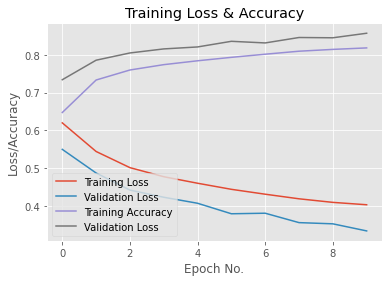

In [ ]:
model.save(MODEL_PATH)
plot_training(history, PLOT_PATH)


Testing the Model

In [ ]:
# Same Pre-Processing as the Images
imageA = np.expand_dims(pairTest[45, 0], axis = -1)
imageB = np.expand_dims(pairTest[45, 0], axis = -1)

imageA = np.expand_dims(imageA, axis = 0)
imageB = np.expand_dims(imageB, axis = 0)
preds = model.predict([imageA, imageB])

print('Predicted Accuracy:', preds[0][0] * 100)

Predicted Accuracy: 98.55135083198547


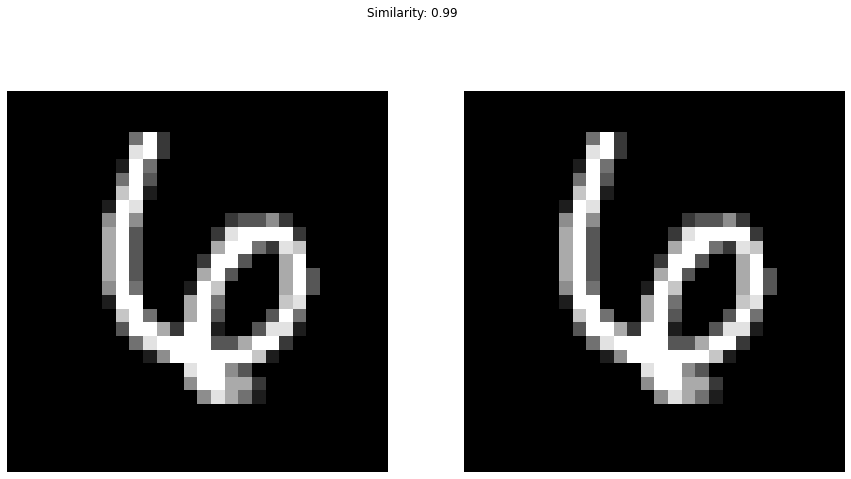

In [ ]:
imageA = np.resize(imageA, (28, 28))
imageB = np.resize(imageB, (28, 28))

fig = plt.figure("Pair #{}".format(i + 1), figsize = (15, 8))
plt.suptitle("Similarity: {:.2f}".format(preds[0][0]))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(imageA, cmap = plt.cm.gray)
plt.axis("off") 

ax = fig.add_subplot(1, 2, 2)
plt.imshow(imageB, cmap = plt.cm.gray)
plt.axis("off")

plt.show()